### Домашнее задание 4. Дизайн вакцины против вируса Зика.

Скачаем последовательности полипротеинов вируса Зика, выравняем с помощью Jalview (алгоритм ClustalW) и вытащим консенсус.

In [ ]:
from Bio import Entrez
from Bio import SeqIO

stream = Entrez.esearch(db="protein", term="(Zika virus[Organism] AND polyprotein[Protein Name]) NOT partial[All Fields]", rettype="fasta", retmax=1228)
record = Entrez.read(stream, ignore_errors=True)
stream.close()
id_list = record["IdList"]

stream = Entrez.efetch(db="protein", id=id_list, rettype="fasta", ignore_errors=True)
records = list(SeqIO.parse(stream, "fasta"))
stream.close()
output_file = "zika_polyprotein.fasta"
SeqIO.write(records, output_file, "fasta")

# я скачивала вручную ~30 последовательностей, т.к. веб-сервисы и JalView (ClustalW) не принимают свыше 3000 последовательностей или с длинами выше 3000 а.о.
# MEGA (ClustalW) очень долго выравнивает

Saved


Аналогично, но ждать скачивания очень долго.

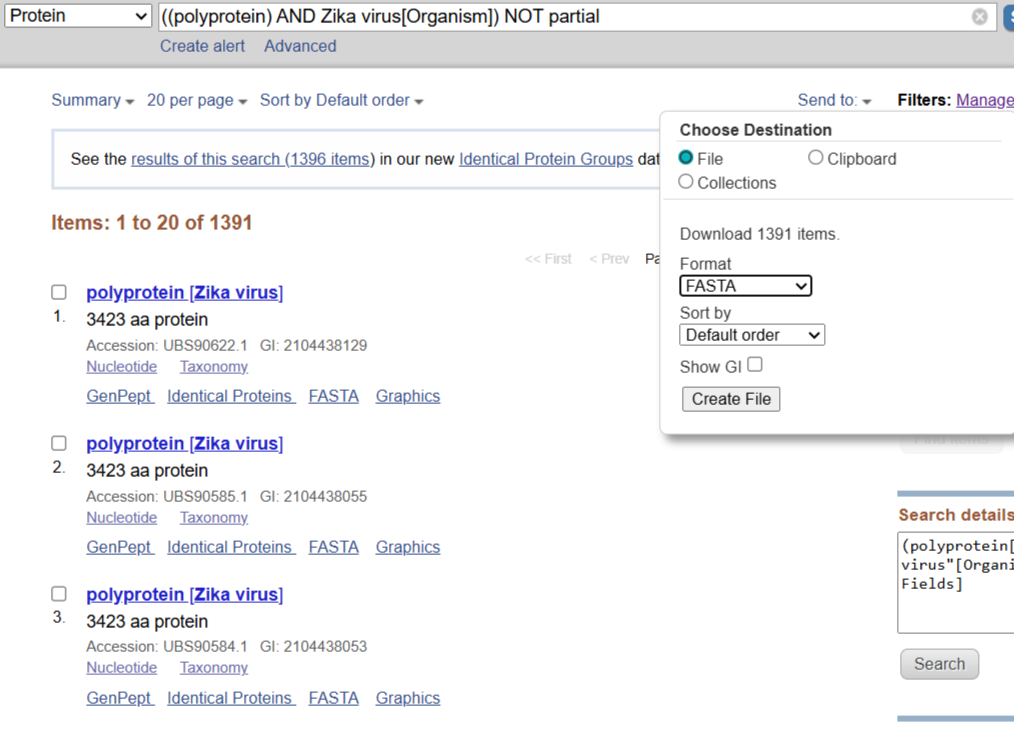

In [ ]:
consensus = SeqIO.read('consensus_polyprotein.fasta', 'fasta')
print('Консенсусная последовательность:', consensus.seq, sep='\n')

Консенсусная последовательность:
MKNPKKKSGGFRIVNMLKRGVARVSPFGGLKRLPAGLLLGHGPIRMVLAILAFLRFTAIKPSLGLINRWGSVGKKEAMEIIKKFKKDLAAMLRIINARKEKKRRGADTSVGIVGLLLTTAMAAEVTRRGSAYYMYLDRSDAGEAISFPTTLGMNKCYIQIMDLGHMCDATMSYECPMLDEGVEPDDVDCWCNTTSTWVVYGTCHHKKGEARRSRRAVTLPSHSTRKLQTRSQTWLESREYTKHLIRVENWIFRNPGFALAAAAIAWLLGSSTSQKVIYLVMILLIAPAYSIRCIGVSNRDFVEGMSGGTWVDVVLEHGGCVTVMAQDKPTVDIELVTTTVSNMAEVRSYCYEASISDMASDSRCPTQGEAYLDKQSDTQYVCKRTLVDRGWGNGCGLFGKGSLVTCAKFACSKKMTGKSIQPENLEYRIMLSVHGSQHSGMIVNDTGHETDENRAKVEITPNSPRAEATLGGFGSLGLDCEPRTGLDFSDLYYLTMNNKHWLVHKEWFHDIPLPWHAGADTGTPHWNNKEALVEFKDAHAKRQTVVVLGSQEGAVHTALAGALEAEMDGAKGRLSSGHLKCRLKMDKLRLKGVSYSLCTAAFTFTKIPAETLHGTVTVEVQYAGTDGPCKVPAQMAVDMQTLTPVGRLITANPVITESTENSKMMLELDPPFGDSYIVIGVGEKKITHHWHRSGSTIGKAFEATVRGAKRMAVLGDTAWDFGSVGGVLNSLGKGIHQIFGAAFKSLFGGMSWFSQILIGTLLMWLGLNTKNGSISLMCLALGGVLIFLSTAVSADVGCSVDFSKKETRCGTGVFVYNDVEAWRDRYKYHPDSPRRLAAAVKQAWEDGICGISSVSRMENIMWRSVEGELNAILEENGVQLTVVVGSVKNPMWRGPQRLPVPVNELPHGWKAWGKSYFVRAAKTNNSFVVDGDTLKECPLKHRAWNSFLVEDHGFGVFHTSVWLKVRE

In [ ]:
# т.к. нам нужны только функциональные белки (неструктурные белки не совсем функциональны), 
# то выделяем только первые три белка: C (белок капсида), prM (Pr - пептид, M - малый белок оболочки), E (белок оболочки)

from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

viral_proteins = [SeqRecord(Seq(consensus.seq[0:122]), # 1-122
                           id= 'Protein C'),
                  SeqRecord(Seq(consensus.seq[123:215]), # 123-215
                           id= 'Peptide Pr'),
                  SeqRecord(Seq(consensus.seq[216:290]), # 216-290
                           id= 'small envelope protein M'),
                  SeqRecord(Seq(consensus.seq[291:794]), # 291-290
                           id= 'envelope protein E')]

with open("viral_proteins.fasta", "w") as output_handle:
    SeqIO.write(viral_proteins, output_handle, "fasta")
output_handle.close()

#### 1. CD8 Epitope Selection

Воспользуемся онлайн-сервисом [NetMHCpan](https://tools.iedb.org/mhci) в БД IEDB для предсказания эпитопа для CD8: длина k-мера = 9 (рекомендовано в методичке), репрезентативные HLA-аллели (список ниже).

Отфильтруем пептиды с отранжированными перцентилями <b>ниже или равно двум</b> - это потенциальные молекулы для связывания ("binders").

Самые распространённые HLA-аллели в российской популяции: [статья](https://cyberleninka.ru/article/n/hla-geneticheskoe-raznoobrazie-russkoy-populyatsii-vyyavlennoe-metodom-sekvenirovaniya-sleduyuschego-pokoleniya#:~:text=Значительным%20HLA%20генетическим%20разнообразием%20популяция,Вы%20всегда%20можете%20отключить%20рекламу).
 
[Список из MHCNet](https://services.healthtech.dtu.dk/services/NetMHC-4.0/MHC_allele_names.txt): HLA-A0201,HLA-A0301,HLA-A0101,HLA-B0702,HLA-A2402,HLA-B1801,HLA-B3501,HLA-B4403,HLA-B5101,HLA-C0702,HLA-C0401,HLA-C0701,HLA-C0602,HLA-C1203

HLA-A*01:01
HLA-A*02:01
HLA-A*03:01
HLA-B*07:02
HLA-A*24:02
HLA-B*35:01
HLA-B*18:01
HLA-B*44:03
HLA-B*51:01
HLA-C*07:02
HLA-C*07:01
HLA-C*04:01
HLA-C*06:02
HLA-C*12:03

In [ ]:
import pandas as pd

MHCI_pred = pd.read_csv('predictions/MHCI.tsv', sep='\t')
MHCI_binders = MHCI_pred.query('percentile_rank <= 2').groupby('seq_num').head(5) # для каждого белка выявляем эпитопы

In [ ]:
# выбираем в пределах координат исследуемых генов
#conditions = [(MHCI_SB['start'] >= 1) & (MHCI_SB['end'] < 123),
#              (MHCI_SB['start'] >= 123) & (MHCI_SB['end'] < 216),
#              (MHCI_SB['start'] >= 216) & (MHCI_SB['end'] < 291),
#              (MHCI_SB['start'] >= 291) & (MHCI_SB['end'] < 794)
#                      ]

# выбираем в пределах исследуемых белков
#seq_nums = [i for i in range(1,5)]

In [46]:
MHCI_binders.peptide.to_csv('predictions/MHCI-binders-list.txt', index=False, header=False) # вытаскиваем список пептидов для дальнейшней валидации

Для валидации эпитопов воспользуемся [IEDB Class I immunogenicity Tool](http://tools.iedb.org/immunogenicity/).

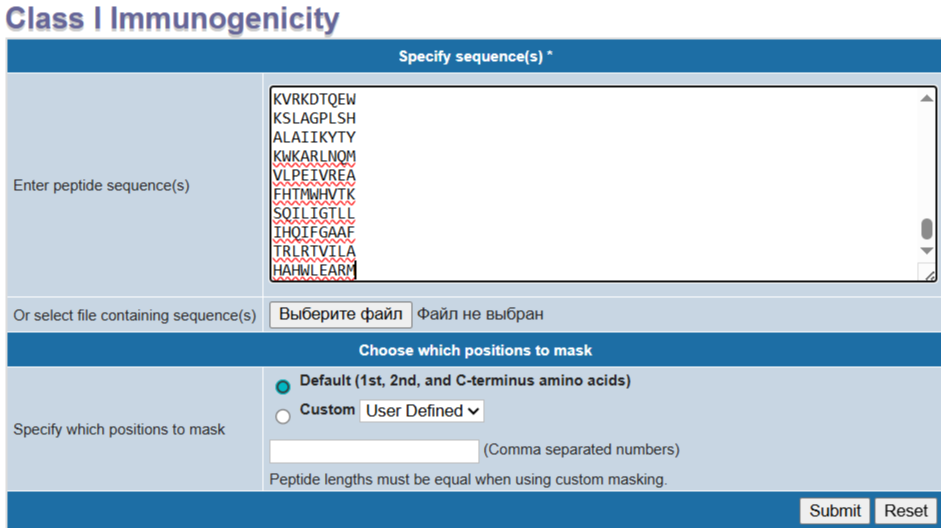

In [70]:
# результат валидации

MHCI_val = pd.read_csv('MHCI-val-result.csv')
immunogenic_MHCI = MHCI_val[MHCI_val['score'] > 0.15].drop_duplicates('peptide').reset_index() # потенциально иммуногенные эпитопы (порог = 0.15)
immunogenic_MHCI

,index,peptide,length,score
0,0,VENWIFRNP,9,0.50049
1,1,IRVENWIFR,9,0.49708
2,2,RAGDITWEK,9,0.44490
3,5,RTTWAENIK,9,0.44014
4,6,TGWDNWEEV,9,0.43943
...,...,...,...,...
304,726,NTTSTWVVY,9,0.15140
305,731,ALALAIIKY,9,0.15124
306,736,SPRRLAAAV,9,0.15079
307,738,CGRGGWSYY,9,0.15063


#### 2. CD4 Epitope Selection

С помощью сервиса [IEDB MHC-II Binding prediction platform](https://tools.iedb.org/mhcii/) предскажем пептиды, связывающиеся с MHC-II. Выбираем DR-участки HLA-локусов (источник информации о распространении HLA-аллелей в российской популяции тот же): DRB1*07:01:01, DRB1*15:01:01, DRB1*01:01:01, DRB1*03:01:01. Длину выбираем, равную 15, как рекомендовано при анализе и поиске эпитопов к CD4. Метод - консенсусный (v. 2. 22).

In [ ]:
MHCII_pred = pd.read_csv('MHCII_consensus_method.tsv', sep='\t').sort_values(by='percentile_rank', ascending=True)
MHCII_binders = MHCII_pred[(MHCII_pred['percentile_rank'] < 1) & (MHCII_pred['smm_align_ic50'] <= 50)] # IC50 ≤ 50 nM, низкий ранжированный перцентиль
MHCII_binders.peptide.to_csv('MHCII-binders-list.txt', index=False, header=False) # вытаскиваем список пептидов для дальнейшней валидации

Валидация - с помощью [IEDB CD4+ T Cell Immunogenicity Prediction Tool](https://tools.iedb.org/CD4episcore/). Параметры по умолчанию, метод - по умолчанию.

In [71]:
# результат валидации

MHCII_val = pd.read_csv('MHCII-val-result.csv')
immunogenic_MHCII = MHCII_val[MHCII_val.sort_values(by='Combined Score')['Combined Score'] < 40].drop_duplicates('Peptide').reset_index() # потенциально иммуногенные эпитопы: выше в списке с низким значением веса при комбинировании двух методов
immunogenic_MHCII

,index,Protein Number,Protein Description,Peptide,Start,End,Combined Score,Immunogenicity Score,Peptide core,Median Percentile Rank (7-allele),HLA-DRB1:03:01,HLA-DRB1:07:01,HLA-DRB1:15:01,HLA-DRB3:01:01,HLA-DRB3:02:02,HLA-DRB4:01:01,HLA-DRB5:01:01
0,0,60,seq60,GDVAHLALVAAFKVR,1,15,26.38536,32.9634,LALVAAFKV,22.0,41.0,0.88,1.50,38.0,26.00,22.0,6.70
1,1,5,seq5,LALVAAFKVRPALLV,1,15,26.45884,45.1471,LALVAAFKV,14.0,14.0,0.10,2.80,17.0,6.40,14.0,18.00
2,2,61,seq61,GGDVAHLALVAAFKV,1,15,27.39716,36.9929,LALVAAFKV,21.0,59.0,0.88,3.50,37.0,34.00,21.0,9.80
3,3,24,seq24,LGIFFVLMRNKGIGK,1,15,29.72868,60.3717,FFVLMRNKG,9.3,23.0,9.30,0.92,16.0,3.00,19.0,0.42
4,4,13,seq13,GIFFVLMRNKGIGKM,1,15,30.19176,61.5294,FFVLMRNKG,9.3,25.0,9.30,0.93,15.0,2.10,19.0,0.42
5,5,4,seq4,LAFLRFTAIKPSLGL,1,15,30.49780,64.0945,FLRFTAIKP,8.1,31.0,2.80,8.10,40.0,3.50,9.0,3.90
6,6,25,seq25,SLGIFFVLMRNKGIG,1,15,31.14420,63.9105,FFVLMRNKG,9.3,23.0,9.30,0.93,16.0,5.70,19.0,0.42
7,7,26,seq26,VSLGIFFVLMRNKGI,1,15,31.68524,65.1131,FFVLMRNKG,9.4,20.0,5.60,0.87,16.0,9.40,19.0,0.42
8,8,22,seq22,IFFVLMRNKGIGKMG,1,15,31.91252,65.8313,FFVLMRNKG,9.3,25.0,9.30,1.10,16.0,2.40,19.0,0.42
9,9,2,seq2,AFLRFTAIKPSLGLI,1,15,34.75900,71.8975,FLRFTAIKP,10.0,31.0,2.80,10.00,42.0,2.90,13.0,4.30


#### 3. IFN-γ-Inducing Epitopes

Предсказываем активацию IFNγ при экспрессии MHCII с помощью [IFNepitope Server](http://crdd.osdd.net/raghava/ifnepitope/predict.php).

In [ ]:
# организуем все найденные эпитопы
temp = []
for i in range(immunogenic_MHCI.peptide.shape[0]):
    temp.append([i, immunogenic_MHCI.peptide[i]])
for k in range(immunogenic_MHCI.peptide.shape[0], immunogenic_MHCI.peptide.shape[0]+immunogenic_MHCII.Peptide.shape[0]):
    temp.append([k, immunogenic_MHCI.peptide[k-immunogenic_MHCI.peptide.shape[0]]])
temp

with open('peptides_list.fasta', 'a') as output:
    for idx, peptide in temp:
        output.write(f'>Epitope_{idx}\n{peptide}\n')
output.close()

In [78]:
# после выдачи результатов

IFN_pred = pd.read_csv('IFNgamma.tsv', sep='\t')
IFN_pred[IFN_pred['Score'] > 0] # индуцируют IFN-gamma

,Serial_No.,Epitope_Name,Sequence,Method,Result,Score
0,1,Epitope_47,VTKWTDIPY,MERCI,POSITIVE,1.000000
1,2,Epitope_79,TYTDRRWCF,MERCI,POSITIVE,1.000000
2,3,Epitope_81,DEDHAHWLE,MERCI,POSITIVE,2.000000
3,4,Epitope_86,TDEDHAHWL,MERCI,POSITIVE,2.000000
4,5,Epitope_92,REEGATIGF,MERCI,POSITIVE,1.000000
...,...,...,...,...,...,...
325,326,Epitope_325,SVPAEVWTR,SVM,POSITIVE,0.056756
326,327,Epitope_326,HAHWLEARM,SVM,POSITIVE,0.876707
327,328,Epitope_327,QSYGWNIVR,SVM,POSITIVE,0.652992
328,329,Epitope_328,LAAAAIAWL,SVM,POSITIVE,0.867769


#### 4. Другие цитокины

In [ ]:
# IL-4
IL_4 = pd.read_csv('IL-4.csv') # IL-4Pred
IL_4

# A-клеточные эпитопы
ACE = pd.read_csv('ACE.csv') # VaxinPAD
ACE

,ID,Seq,SS,Pred,Hphob,pI,Mwt
0,Epitope_99,YAWDFGVPL,-0.14,Non-IM,0.19,3.80,1067.33
1,Epitope_98,SRKTFETEF,-0.78,Non-IM,-0.39,6.49,1144.36
2,Epitope_97,DGDIGAVAL,-0.56,Non-IM,0.13,3.57,830.01
3,Epitope_96,YGWNIVRLK,0.39,IM,-0.13,10.01,1148.50
4,Epitope_95,DPAVIGTAV,-0.06,Non-IM,0.17,3.80,842.07
...,...,...,...,...,...,...,...
325,Epitope_101,NRIERIRSE,0.61,IM,-0.66,9.86,1172.41
326,Epitope_100,MQEGVFHTM,-0.19,Non-IM,-0.01,5.25,1079.39
327,Epitope_10,ALAWLAIRA,0.37,IM,0.16,10.11,984.31
328,Epitope_1,IRVENWIFR,0.06,IM,-0.20,9.95,1232.57


#### 5. IEDB Population Coverage

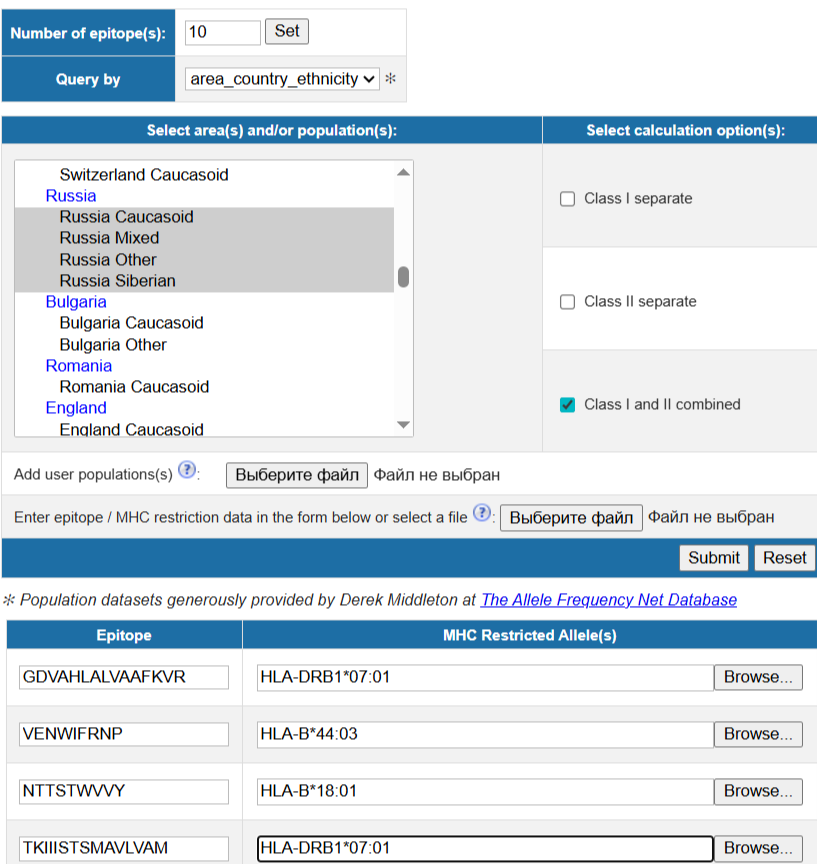

Результаты:

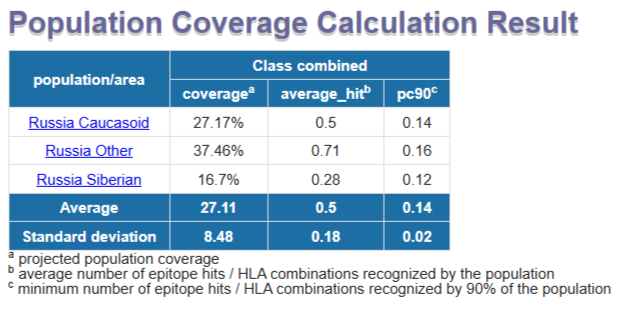

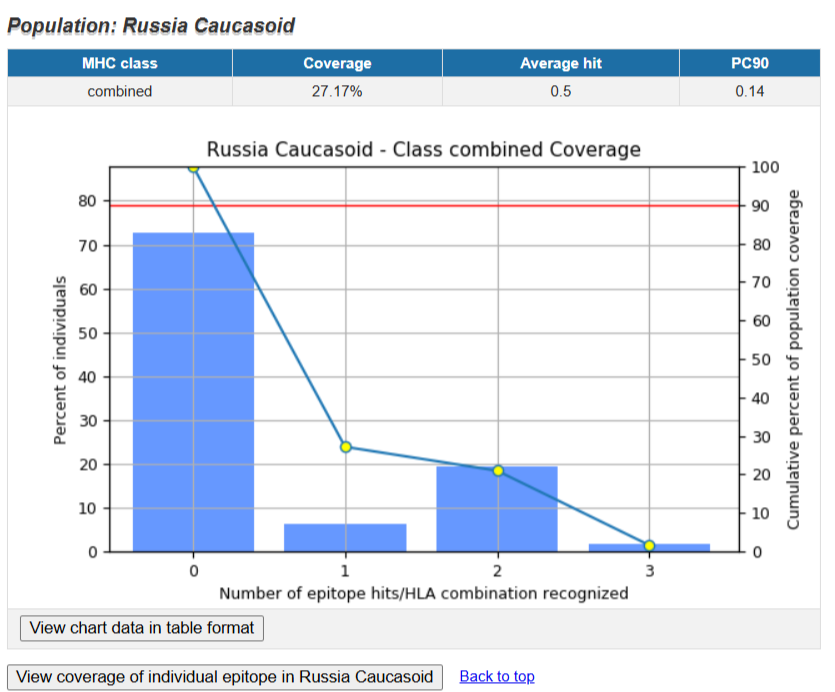

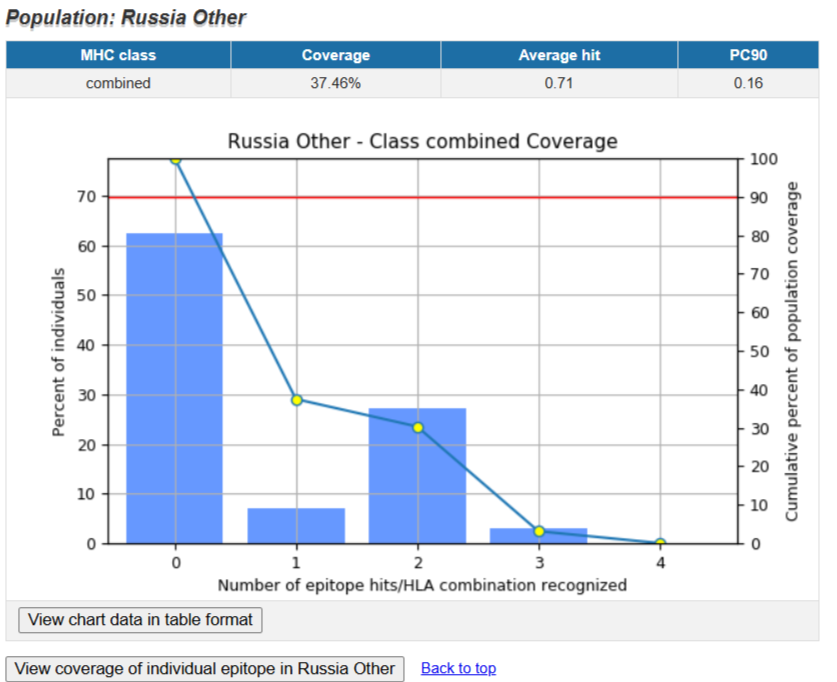

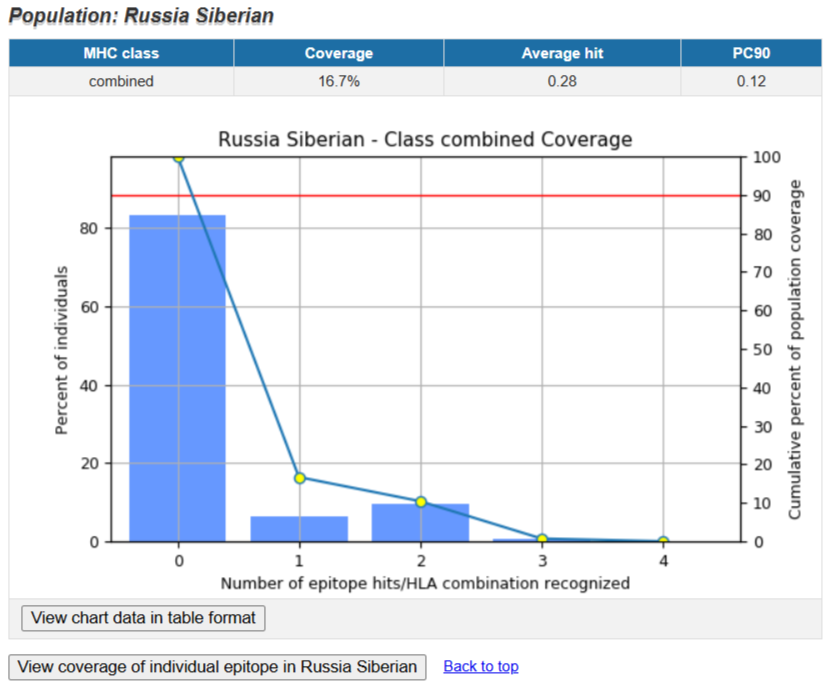

#### 6. B-клеточные эпитопы (BCL)

С помощью BepiPred 2.0 (https://services.healthtech.dtu.dk/service.php?BepiPred-2.0).

In [ ]:
# B-клеточные эпитопы
B_cell_epitope = pd.read_csv('bepipred_results.csv')
BCL_filtered = B_cell_epitope[B_cell_epitope['EpitopeProbability'] >= 0.50]
BCL_filtered['diffgroup'] = (BCL_filtered['Position'].diff() != 1).cumsum() # делаем группировку по соседним позициям
BCL_filtered['epitope_seqs'] = BCL_filtered.groupby(['Entry', 'diffgroup'])['AminoAcid'].transform(lambda x : ''.join(x)) # соединяем отдельные аминокислоты в единую последовательность
BCL_filtered = BCL_filtered.drop_duplicates('epitope_seqs')
BCL_df = BCL_filtered[BCL_filtered['epitope_seqs'].str.len() != 1][['Entry', 'epitope_seqs']]
BCL_df.to_csv('B-cell-epitopes.csv', index=False)
BCL_df

#### 7. Дизайн струтктуры вакцины

* Линкеры: 
'''AAY linkers, for instance, are commonly used to separate TCD8+
peptides because they produce suitable sites for binding to TAP
transporter [35–37]. GPGPG linkers have been shown to induce
helper T cell responses and are usually placed between these cells’
peptides in the vaccine structure [36, 38, 39]. For B cell linear
epitopes, KK linkers are the most used [36, 40]. DNTAN [41] and
EAAK [36, 42] are good options to connect the adjuvant to the rest
of the vaccine sequence because they provide flexibility to the
protein structure.'''
* Адъювант: бактериальный флагеллин, Heparin-binding hemagglutinin and 50S ribosomal protein L7/L12, or synthesized such as peptide RS09 (APPHALS) от <i>Mycobacterium tuberculosis</i>

Оценка вакцины:

* Аллергенность: с помощью [сервиса](http://ddg-pharmfac.net/AllergenFP/method.html) производится оценка аллергенности сконструированной вакцины.
* Антигенность: с помощью [VaxiJen](http://www.ddg-pharmfac.net/vaxijen/VaxiJen/VaxiJen.html) (порог = 0.4).
* Аутоиммунная реакция: с помощью [BLASTP](https://blast.ncbi.nlm.nih.gov/Blast.cgi?PAGE=Proteins) (параметры: Standard databases (nr) -> Non-redundant protein sequences, taxid: 9606).
* Физ.-хим. свойства: ProtParam

Предсказание вторичной структуры: PSIPRED (http://bioinf.cs.ucl.ac.uk/psipred/) and JPred (https://www.compbio.dundee.ac.uk/jpred/).

Предсказание третичной структуры: e Protein Homology/analogY Recognition Engine V 2.0 (Phyre2) (http://www.sbg.bio.ic.ac.uk/~phyre2/html/page.cgi?id=index).

Валидация: ReFOLD (https://www.reading.ac.uk/bioinf/ReFOLD/ReFOLD3_form.html), The Ramachandran plot server (https://zlab.umassmed.edu/bu/rama/)

Предсказание BCL-эпитопа с помощью третичной структуры: [Ellipro](http://tools.iedb.org/ellipro/)